# Actor Collaboration Network

In [1]:
import csv
import pandas as pd
from collections import Counter
from itertools import permutations
from itertools import combinations
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
import networkx as nx
import random 

In [2]:
file_movies = 'title.basics.tsv/title.basics.tsv'
movies = pd.read_csv(file_movies, sep='\t', na_values='\\N', dtype={
    'tconst': 'str',
    'titleType': 'str',
    'primaryTitle': 'str',
    'startYear': 'Int64',
}, usecols=['tconst', 'titleType', 'primaryTitle', 'startYear']).set_index('tconst')

In [3]:
movies = movies[(movies['startYear'] >= 2003) & (movies['titleType'] == 'movie')] #try 1983
del movies['titleType']

In [4]:
file_akas = 'title.akas.tsv/title.akas.tsv'
akas_data = pd.read_csv(file_akas, sep='\t', na_values='\\N', dtype={
    'titleId': 'str',
    'ordering': 'int',
    'title': 'str',
    'region': 'str',
    'language': 'str',
    'types': 'str',
    'attributes': 'str',
})

In [5]:
#filter the regions
allowed_regions = ['GB']
filtered_akas_data = akas_data[(akas_data['region'].isin(allowed_regions)) & (akas_data['ordering'] == 1)]
unique_title_ids = filtered_akas_data['titleId'].unique()
final_movies = movies[movies.index.isin(unique_title_ids)]

In [6]:
file_cast = 'title.principals.tsv/title.principal.tsv'
cast = pd.read_csv(file_cast, sep='\t', na_values='\\N', dtype={
    'tconst': 'str',
    'nconst': 'str',
    'category': 'str',
}, usecols=['tconst', 'nconst', 'category'])

In [7]:
cast = cast[cast.category.isin({'actor', 'actress'}) & cast['tconst'].isin(final_movies.index)]
cast.reset_index(drop=True, inplace=True)

In [8]:
#we create a bipartite network:
B = nx.Graph()

actors = cast['nconst'].unique()
movies = final_movies.index.unique()

B.add_nodes_from(actors, bipartite=0)  # Actors belong to set 0
B.add_nodes_from(movies, bipartite=1)  # Movies belong to set 1


for _, row in cast.iterrows():
    actor = row['nconst']
    movie = row['tconst']
    B.add_edge(actor, movie)

In [9]:
print("Number of Actors:", len(actors))
print("Number of Movies:", len(movies))

Number of Actors: 43983
Number of Movies: 17699


In [10]:
proj_actors= bipartite.projected_graph(B, actors)

In [11]:
nx.is_bipartite(proj_actors)

False

In [12]:
nx.is_connected(proj_actors)

False

In [13]:
conn_comp=[len(c) for c in sorted(nx.connected_components(proj_actors), key=len, reverse=True)]

In [14]:
largest_cc = max(nx.connected_components(proj_actors), key=len)

In [15]:
print("Number of Actors:", len(largest_cc))

Number of Actors: 12717


In [16]:
A = proj_actors.subgraph(largest_cc)

In [17]:
A.number_of_nodes()

12717

In [18]:
nx.is_connected(A)

True

In [19]:
initial_graph=A.copy()
nx.is_connected(initial_graph)

True

In [20]:
import time
start = time.time()
diameter = nx.diameter(A)
end = time.time()

In [21]:
print("Time taken =", end-start, "seconds")

Time taken = 885.2624042034149 seconds


In [22]:
print(diameter)

37


# Centrality measures

In [23]:
#degree centrality 
D = nx.degree_centrality(A)

In [24]:
import networkx as nx
import matplotlib.pyplot as plt
import random

# Initialize lists to store results
fraction_removed1 = []
diameters1 = []

initial_graph1=A.copy()

# Set the number of nodes to remove at each iteration
nodes_to_remove = 300

# Get the initial number of nodes in the graph
initial_node_count = len(initial_graph1.nodes())


# Loop to iteratively remove nodes and compute diameter, whit the subscript 1 we refer to the removal a random sample,
#while with the subscript 2 we refer tot eh removal of the nodes with the largest connectivity
while len(initial_graph1.nodes()) > nodes_to_remove:
    
    # Randomly sample nodes to remove
    nodes_to_remove_list1 = random.sample(initial_graph1.nodes, nodes_to_remove)

    
    # Create a copy of the graph and remove the sampled nodes
    new_graph1 = initial_graph1.copy()
    tmp1=new_graph1.remove_nodes_from(nodes_to_remove_list1)
    tmp_graph1=new_graph1.subgraph(tmp1) 
   
    
    largest_cc_tmp1=max(nx.connected_components(tmp_graph1), key=len)
    initial_graph1=tmp_graph1.subgraph(largest_cc_tmp1)
    

    # Compute the diameter of the remaining graph
    diameter1 = nx.diameter(initial_graph1)
    
    # Calculate the fraction of removed nodes
    removed_fraction1 = (initial_node_count - len(initial_graph1.nodes())) / initial_node_count
    
    # Append results to lists
    fraction_removed1.append(removed_fraction1)
    diameters1.append(diameter1)

    print(len(initial_graph1.nodes()))

/var/folders/qc/xq4mp0092_jcyglsdj9mtc440000gn/T/ipykernel_60128/1607284615.py:23: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  nodes_to_remove_list1 = random.sample(initial_graph1.nodes, nodes_to_remove)


11986
11139
10392
9476
8773
7121
6084
5247
4093
3085
2039
463
22


In [25]:
# Initialize lists to store results
fraction_removed2 = []
diameters2 = []

# Assuming you already have the graph 'A' defined
initial_graph2 = A.copy()

# Set the number of nodes to remove at each iteration
nodes_to_remove = 50

# Get the initial number of nodes in the graph
initial_node_count = len(initial_graph2.nodes())

# Loop to iteratively remove nodes and compute diameter for initial_graph2
while len(initial_graph2.nodes()) > nodes_to_remove:
    
    # Calculate degree centrality for all nodes
    degree_centrality = nx.degree_centrality(initial_graph2)
    
    # Sort nodes by degree centrality in descending order
    sorted_nodes_by_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
    
    # Get the top 300 nodes with highest degree centrality
    nodes_to_remove_list2 = [node for node, centrality in sorted_nodes_by_centrality[:nodes_to_remove]]
    
    # Create a copy of the graph and remove the nodes with highest degree centrality
    new_graph2 = initial_graph2.copy()
    new_graph2.remove_nodes_from(nodes_to_remove_list2)
    
    # Compute the diameter of the remaining graph
    largest_cc_tmp2 = max(nx.connected_components(new_graph2), key=len)
    initial_graph2 = new_graph2.subgraph(largest_cc_tmp2)
    diameter2 = nx.diameter(initial_graph2)
    
    # Calculate the fraction of removed nodes
    removed_fraction2 = (initial_node_count - len(initial_graph2.nodes())) / initial_node_count
    
    # Append results to lists
    fraction_removed2.append(removed_fraction2)
    diameters2.append(diameter2)
    print(len(initial_graph2.nodes()))

11357
10106
9205
8159
6444
5214
3112
651
46


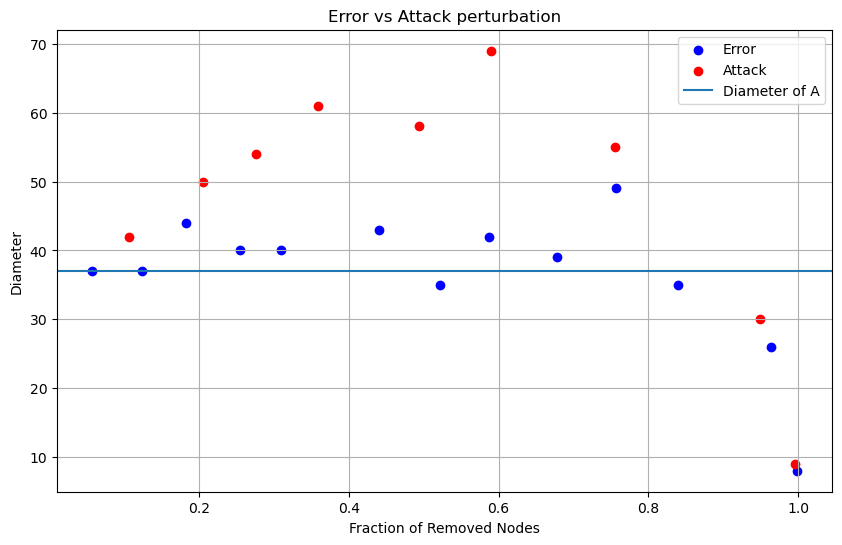

In [28]:
# Plot the changes in diameter as a function of the fraction of removed nodes
plt.figure(figsize=(10, 6))
plt.scatter(fraction_removed1, diameters1, marker='o', linestyle='-', color='b',label='Error')
plt.scatter(fraction_removed2, diameters2, marker='o', linestyle='-', color='r',label='Attack')
plt.xlabel('Fraction of Removed Nodes')
plt.ylabel('Diameter')
plt.axhline(diameter, label='Diameter of A')
plt.title('Error vs Attack perturbation')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()
